### Loading Data

In [3]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [7]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import random

random.seed(42)

class SampledCelebA(Dataset):
    def __init__(self, root_dir, attr_path, transform=None, sample_size=5000, seed=42):
        """
        Args:
            root_dir (string): Directory with all the images.
            attr_path (string): Path to attributes file.
            transform (callable, optional): Optional transform to be applied on a sample.
            sample_size (int): Number of images to sample from the dataset.
            seed (int): Random seed for reproducibility.
        """
        self.root_dir = root_dir
        self.transform = transform
        
        # Set random seed for reproducibility
        random.seed(seed)
        
        # Get all image filenames
        all_image_files = os.listdir(root_dir)
        
        # Sample a subset of images
        self.sample_size = min(sample_size, len(all_image_files))
        self.image_files = random.sample(all_image_files, self.sample_size)
        
        # Read attributes (optional)
        try:
            self.attr_df = pd.read_csv(attr_path, delim_whitespace=True, header=1)
        except:
            print("Warning: Could not read attributes file. Will return zero attributes.")
            self.attr_df = None

    def __len__(self):
        return self.sample_size
        
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')  # Ensure RGB format
        
        # Default empty attributes tensor
        attributes = torch.zeros(40, dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
            
        return image, attributes

# Define transforms
transform_raw = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Create dataset with a smaller sample
sample_size = 80000  # Change this to your desired sample size
celeba_dataset = SampledCelebA(
    root_dir='data/celeba/images/',
    attr_path='data/celeba/list_attr_celeba.txt',
    transform=transform_raw,
    sample_size=sample_size
)

# Create train/test split (80/20)
train_size = int(0.8 * len(celeba_dataset))
test_size = len(celeba_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    celeba_dataset, [train_size, test_size]
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2
)

print(f"Dataset loaded with {sample_size} images")
print(f"Training set: {train_size} images")
print(f"Testing set: {test_size} images")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/tmp/ipykernel_28268/1594015794.py:36: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.attr_df = pd.read_csv(attr_path, delim_whitespace=True, header=1)


Dataset loaded with 80000 images
Training set: 64000 images
Testing set: 16000 images


### Original SuperRes Pipeline

In [10]:
# -------- Traditional Functions --------
def apply_white_balance(img_tensor, gains=(1.2, 1.0, 0.9)):
    img = img_tensor.clone()
    img[0] *= gains[0]
    img[1] *= gains[1]
    img[2] *= gains[2]
    return torch.clamp(img, 0, 1)

def apply_gaussian_blur(img_tensor, ksize=5, sigma=1.5):
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * 255).astype(np.uint8)
    img_blurred = cv2.GaussianBlur(img_np, (ksize, ksize), sigma)
    img_tensor_blurred = torch.from_numpy(img_blurred.astype(np.float32) / 255.0).permute(2, 0, 1)
    return img_tensor_blurred

def apply_gamma_correction(img_tensor, gamma=2.2):
    return torch.clamp(img_tensor, 1e-8, 1.0) ** (1 / gamma)

# -------- Super-Resolution Neural Network --------
class UpsampleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.upsample = nn.Sequential(
            nn.Conv2d(3, 64, 5, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(64, 3, 3, padding=1)
        )

    def forward(self, x):
        return self.upsample(x)

In [14]:
model = UpsampleCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# -------- Training --------
for epoch in range(75):
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        batch_lr = []

        for img in images:
            img_lr = torch.nn.functional.interpolate(img.unsqueeze(0), scale_factor=0.5, mode='bicubic', align_corners=False).squeeze(0)
            img_lr = apply_white_balance(img_lr)
            img_lr = apply_gaussian_blur(img_lr)
            img_lr = apply_gamma_correction(img_lr)
            batch_lr.append(img_lr)

        batch_lr = torch.stack(batch_lr).to(device)

        # Forward
        outputs = model(batch_lr)
        loss = criterion(outputs, images)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/75, Total_loss:{total_loss}")

# -------- Save Model --------
torch.save(model.state_dict(), "traditional_to_trainable_sr.pth")
print("Model saved to traditional_to_trainable_sr.pth")

Epoch 1/75, Total_loss:43.82221420528367
Epoch 2/75, Total_loss:33.945744001772255
Epoch 3/75, Total_loss:31.240497386548668
Epoch 4/75, Total_loss:29.772223636158742
Epoch 5/75, Total_loss:28.873597659752704
Epoch 6/75, Total_loss:28.338986251619644
Epoch 7/75, Total_loss:27.95604295656085
Epoch 8/75, Total_loss:27.66517478041351
Epoch 9/75, Total_loss:27.405623604543507
Epoch 10/75, Total_loss:27.17839521483984
Epoch 11/75, Total_loss:27.022997166379355
Epoch 12/75, Total_loss:26.8626540718833
Epoch 13/75, Total_loss:26.70201218232978
Epoch 14/75, Total_loss:26.61454750446137
Epoch 15/75, Total_loss:26.545462472829968
Epoch 16/75, Total_loss:26.351703247637488
Epoch 17/75, Total_loss:26.271921916748397
Epoch 18/75, Total_loss:26.17485542758368
Epoch 19/75, Total_loss:26.077887693420053
Epoch 20/75, Total_loss:26.019677102332935
Epoch 21/75, Total_loss:25.949422194156796
Epoch 22/75, Total_loss:25.87108245329
Epoch 23/75, Total_loss:25.811684607178904
Epoch 24/75, Total_loss:25.756816

In [16]:
# -------- Metrics for comparison --------
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def calculate_metrics(original, generated):
    """Calculate PSNR and SSIM between original and generated images"""
    original_np = original.permute(1, 2, 0).cpu().numpy()
    generated_np = generated.permute(1, 2, 0).cpu().numpy()
    
    # Clip values to valid range for metrics
    original_np = np.clip(original_np, 0, 1)
    generated_np = np.clip(generated_np, 0, 1)
    
    # Calculate PSNR
    psnr_value = psnr(original_np, generated_np, data_range=1.0)
    
    # Calculate SSIM (channel by channel for color images)
    ssim_value = ssim(original_np, generated_np, data_range=1.0, channel_axis=2, multichannel=True)
    
    return psnr_value, ssim_value

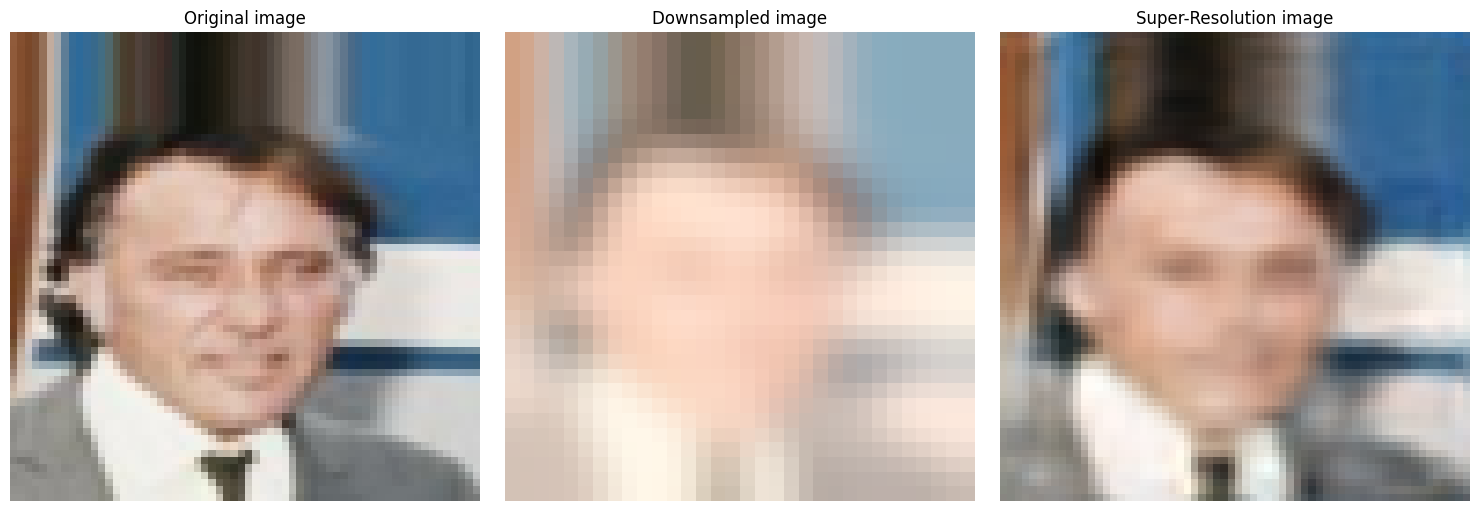

SR Model - Avg PSNR: 25.15 dB, Avg SSIM: 0.8138


In [ ]:
# Add this at the end of your evaluation section
model.eval()
total_psnr_bicubic = 0
total_ssim_bicubic = 0
total_psnr_sr = 0
total_ssim_sr = 0
num_images = 0

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        batch_lr = []

        for img in images:
            # Downsample
            img_lr = torch.nn.functional.interpolate(img.unsqueeze(0), scale_factor=0.5, 
                                                   mode='bicubic', align_corners=False).squeeze(0)
            # Apply traditional processing
            img_lr = apply_white_balance(img_lr)
            img_lr = apply_gaussian_blur(img_lr)
            img_lr = apply_gamma_correction(img_lr)
                        
            batch_lr.append(img_lr)

        batch_lr = torch.stack(batch_lr).to(device)        
        outputs = model(batch_lr)

        # Calculate metrics
        for i in range(len(images)):
            # Calculate metrics for our SR model
            psnr_sr, ssim_sr = calculate_metrics(images[i], outputs[i])
            total_psnr_sr += psnr_sr
            total_ssim_sr += ssim_sr
            
            num_images += 1
            
            # Visualize a few examples
            if num_images == 1:
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                axs[0].imshow(images[i].permute(1, 2, 0).cpu())
                axs[0].set_title(f"Original image")
                axs[0].axis('off')
               
               
                axs[1].imshow(batch_lr[i].permute(1, 2, 0).cpu())
                axs[1].set_title(f"Downsampled image")
                axs[1].axis('off')

                axs[2].imshow(outputs[i].permute(1, 2, 0).clamp(0, 1).cpu())
                axs[2].set_title(f"Super-Resolution image")
                axs[2].axis('off')
                
                plt.tight_layout()
                plt.show()
        
        # Process a certain number of batches for evaluation
        if num_images >= 100:
            break

# Print average metrics
avg_psnr_sr = total_psnr_sr / num_images
avg_ssim_sr = total_ssim_sr / num_images

print(f"SR Model - Avg PSNR: {avg_psnr_sr:.2f} dB, Avg SSIM: {avg_ssim_sr:.4f}")

### Differentiable

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# -------- Differentiable White Balance --------
class WhiteBalance(nn.Module):
    def __init__(self, init_gains=(1.2, 1.0, 0.9)):
        super().__init__()
        self.gains = nn.Parameter(torch.tensor(init_gains, dtype=torch.float32))  # Literature-based init

    def forward(self, x):
        return x * self.gains.view(1, -1, 1, 1)

# -------- Differentiable Gaussian Blur --------
class GaussianBlur(nn.Module):
    def __init__(self, kernel_size=5, sigma=1.5):  # Literature-based sigma
        super().__init__()
        self.kernel_size = kernel_size
        self.sigma = sigma

    def forward(self, x):
        channels = x.shape[1]
        kernel_1d = torch.arange(self.kernel_size, dtype=torch.float32) - self.kernel_size // 2
        kernel_1d = torch.exp(-kernel_1d ** 2 / (2 * self.sigma ** 2))
        kernel_1d = kernel_1d / kernel_1d.sum()
        kernel_2d = torch.outer(kernel_1d, kernel_1d)
        kernel = kernel_2d.expand(channels, 1, -1, -1).to(x.device)
        return F.conv2d(x, kernel, padding=self.kernel_size // 2, groups=channels)

# -------- Differentiable Tone Mapping (Gamma Correction) --------
class GammaCorrection(nn.Module):
    def __init__(self, init_gamma=2.2):  # Standard sRGB gamma
        super().__init__()
        self.gamma = nn.Parameter(torch.tensor(init_gamma))

    def forward(self, x):
        return torch.clamp(x, 1e-8, 1) ** (1 / self.gamma)

# -------- Camera Super-Resolution Pipeline --------
class CameraSuperResPipeline(nn.Module):
    def __init__(self):
        super().__init__()
        self.white_balance = WhiteBalance(init_gains=(1.2, 1.0, 0.9))   # Literature-based RGB balance
        self.blur = GaussianBlur(kernel_size=5, sigma=1.5)              # Literature-based lens blur
        self.tone = GammaCorrection(init_gamma=2.2)                     # sRGB gamma
        self.upsample = UpsampleCNN()                                   # Learnable SR network

    def forward(self, x_hr):
        x_lr = self.white_balance(x_hr)
        x_lr = self.blur(x_lr)
        x_lr = self.tone(x_lr)
        x_sr = self.upsample(x_lr)
        return x_sr


In [24]:
model = CameraSuperResPipeline().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# -------- Training --------
for epoch in range(20):
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        batch_lr = []

        for img in images:
            img_lr = torch.nn.functional.interpolate(img.unsqueeze(0), scale_factor=0.5, mode='bicubic', align_corners=False).squeeze(0)
            batch_lr.append(img_lr)

        batch_lr = torch.stack(batch_lr).to(device)

        # Forward
        outputs = model(batch_lr)
        loss = criterion(outputs, images)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/20, Total_loss:{total_loss}")

# -------- Save Model --------
torch.save(model.state_dict(), "differentiable_sr_v1.pth")
print("Model saved to traditional_to_trainable_sr.pth")

Epoch 1/20, Total_loss:40.06562668457627
Epoch 2/20, Total_loss:29.427243650890887
Epoch 3/20, Total_loss:27.01599584869109
Epoch 4/20, Total_loss:25.719864230253734
Epoch 5/20, Total_loss:24.97661267290823
Epoch 6/20, Total_loss:24.475874406984076
Epoch 7/20, Total_loss:24.1283850686159
Epoch 8/20, Total_loss:23.84170142246876
Epoch 9/20, Total_loss:23.619865869753994
Epoch 10/20, Total_loss:23.423552116611972
Epoch 11/20, Total_loss:23.24133549432736
Epoch 12/20, Total_loss:23.101975842844695
Epoch 13/20, Total_loss:22.973518500220962
Epoch 14/20, Total_loss:22.862533899606206
Epoch 15/20, Total_loss:22.780310789239593
Epoch 16/20, Total_loss:22.697076173499227
Epoch 17/20, Total_loss:22.608296852442436
Epoch 18/20, Total_loss:22.551111543900333
Epoch 19/20, Total_loss:22.469289765926078
Epoch 20/20, Total_loss:22.407653601723723
Model saved to traditional_to_trainable_sr.pth


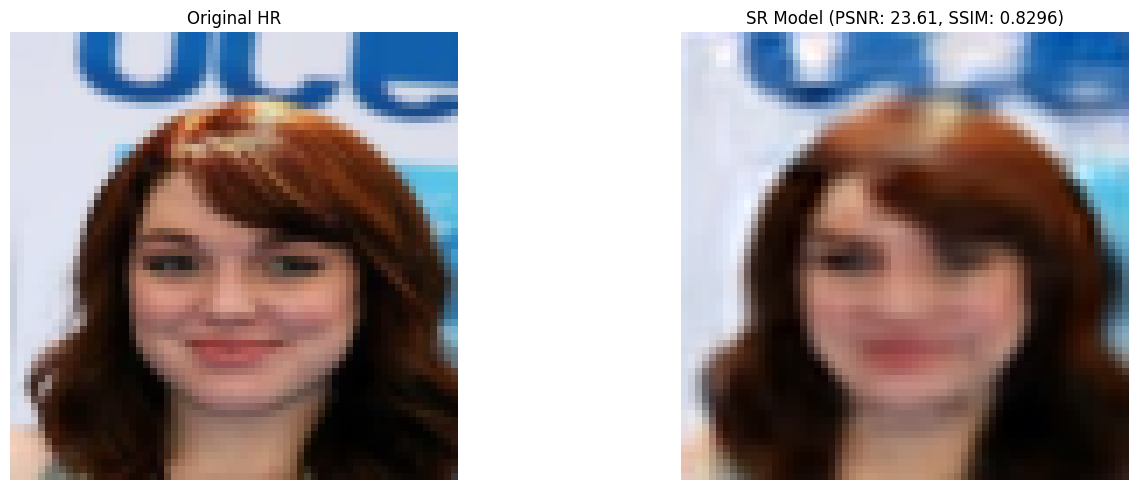

SR Model - Avg PSNR: 26.11 dB, Avg SSIM: 0.8350


In [27]:
# Add this at the end of your evaluation section
model.eval()
total_psnr_bicubic = 0
total_ssim_bicubic = 0
total_psnr_sr = 0
total_ssim_sr = 0
num_images = 0

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        batch_lr = []

        for img in images:
            # Downsample
            img_lr = torch.nn.functional.interpolate(img.unsqueeze(0), scale_factor=0.5, 
                                                   mode='bicubic', align_corners=False).squeeze(0)
            batch_lr.append(img_lr)

        batch_lr = torch.stack(batch_lr).to(device)        
        outputs = model(batch_lr)

        # Calculate metrics
        for i in range(len(images)):
            # Calculate metrics for our SR model
            psnr_sr, ssim_sr = calculate_metrics(images[i], outputs[i])
            total_psnr_sr += psnr_sr
            total_ssim_sr += ssim_sr
            
            num_images += 1
            
            # Visualize a few examples
            if num_images == 1:
                fig, axs = plt.subplots(1, 2, figsize=(15, 5))
                axs[0].imshow(images[i].permute(1, 2, 0).cpu())
                axs[0].set_title(f"Original HR")
                axs[0].axis('off')
               
                axs[1].imshow(outputs[i].permute(1, 2, 0).clamp(0, 1).cpu())
                axs[1].set_title(f"SR Model (PSNR: {psnr_sr:.2f}, SSIM: {ssim_sr:.4f})")
                axs[1].axis('off')
                
                plt.tight_layout()
                plt.show()
        
        # Process a certain number of batches for evaluation
        if num_images >= 100:
            break

# Print average metrics
avg_psnr_sr = total_psnr_sr / num_images
avg_ssim_sr = total_ssim_sr / num_images

print(f"SR Model - Avg PSNR: {avg_psnr_sr:.2f} dB, Avg SSIM: {avg_ssim_sr:.4f}")